# On phasors in least squares solvers

In [112]:
import numpy as np
import matplotlib.pyplot as plt

For the record, and for later use, we will define our least-squares problem as being the minimization of a residual, traditionally denoted $\chi^2$, of a function $f(\vec{p})$ where $\vec{p} = p_i$, $1 \le i \le M$.

We define $\vec{r} = f(\vec{p})$ and $\chi^2 = \sum_1^N r_i^2$. In least squares solvers as provided in many scientific libraries, including `scipy`, it is assumed that parameters and residual vectors have real components.

The `scipy.least_squares` documentation even gives [an example](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html) of how to wrap a complex function of a complex variable so as to pretend each complex dimension is two distinct real ones:
```
def f_wrap(x):
    fx = f(x[0] + 1j*x[1])
    return np.array([fx.real, fx.imag])
```

The reason this works is that a least squared solver sums the squares of the components of the residual vector to form $\chi^2$ and it is a property of a complex number $z=a + i b$ that $\lVert z\rVert^2 = a^2 + b^2$, so doubling the dimension of $\vec{r}$ and counting the real and imaginary components as seperate dimensions has exactly the semantics we intend.

And that's fine. I'd like native complex support but I can live with this. AIPS FRING does this for its global least-squares solver and CASA's `fringefit` task follows FRING's example here as it does everywhere else.

But in fact in fringefitting we actually make models with *phasors*, i.e., complex numbers of unit size, representable as $\Phi = e^{i\phi}$ and using two dimensions per phasor is using twice as many dimensions as you could reasonably expect to need for this.

(You could go even further and say that really we are modelling each visibility's phase and phase is an angle, so maybe we don't need complex numbers at all, but we will see below that $2\pi$ phase-wrapping is real and does present at the very least some wrinkles if you try to go that way.)

My purpose in this memo is to argue that we can and should use a one-dimension-per-phasor representation for this problem and to show in too much detail exactly how.

## Distance between phasors 

Suppose we have two phasors, $\Phi_0 = e^{i\alpha}$ and $\Phi_1 = e^{i\beta}$ and we want to calculate the absolute value of the difference between them $\lVert \Phi_0 - \Phi_1\rVert$. We define further $\mu = \alpha + \beta$ and $\Delta \phi = \beta - \alpha$.


### The easy way

![title](Img/figure1-cropped.png)


As we see from the diagram, $\lVert \Delta\phi \rVert = 2\sin\left(\frac{\Delta\phi}{2}\right)$.

### The slightly less easy way

But if you don't like diagrams in general or you don't like my diagrams in particular, we can get the same result with some algebra instead.

\begin{align}
 \Delta\Phi = e^{i \alpha} - e^{i \beta} &= \exp\left(i \left[\frac{\alpha+\beta}{2} +  \frac{\alpha-\beta}{2}\right]\right) 
 -  \exp\left(i \left[\frac{\alpha+\beta}{2} -  \frac{\alpha-\beta}{2}\right]\right) \\
     &= \exp \left(i \left[\mu + \frac{\Delta\phi}{2}\right]\right) - \exp \left(i \left[\mu - \frac{\Delta\phi}{2}\right]\right) \\
    &= e^{i\mu} \left(\exp \left[i \frac{\Delta\phi}{2}\right] -  \exp \left[-i\frac{\Delta\phi}{2}\right]\right) \\
    &= e^{i\mu} \cdot 2i\sin\left(\frac{\Delta\phi}{2}\right)
\end{align}

So that when we take the absolute magnitude this simplifies down to
\begin{equation}
\lVert \Delta\Phi \rVert = 2\sin\left(\frac{\Delta\phi}{2}\right).
\end{equation}

Frankly I think we should have just believed the diagram, I didn't enjoy typing that out at all.

## But wait! What about derivatives?!

Now it's not quite enough to make sure that $\vec{r}$ contributes correctly to $\chi^2$: many least-squared solvers use the jacobian of the residual function $\frac{\partial r_i}{\partial p_j}$ as part of their iterative minimization strategy, so we also need derivatives to behave reasonably.

And this is where it becomes awkward to advocate for using a model for $\phi$ directly in the solver. We can reasonably claim that the difference between two angles can increase linearly up to $\pi$ and then decrease linearly back down to zero, and we can certainly also write that down in functional form or code it up, but as you can see from the diagram below, the derivative is not especially well behaved *at* $\pi$ and that might cause trouble.

Note that our real one dimensional encoding of $r_i$ is, because of the small angle approximation, the same as the piecewise linear one for small angles, and that it is quite important for it to be signed even though $\chi^2$ doesn't see a difference after squaring the components: the derivative for a given parameter needs to know if it pushes the components it affects up or down!

In [113]:
xs0 = np.linspace(-1, 1, 241)
xs = xs0 * 2 * np.pi

ys1 = 2 * np.sin(xs / 2)
ys2 = (xs + np.pi) % (2 * np.pi) - np.pi
ys3 = np.abs(ys2)
ys4 = np.pi - np.abs((xs + np.pi) % (4 * np.pi) - 2 * np.pi)

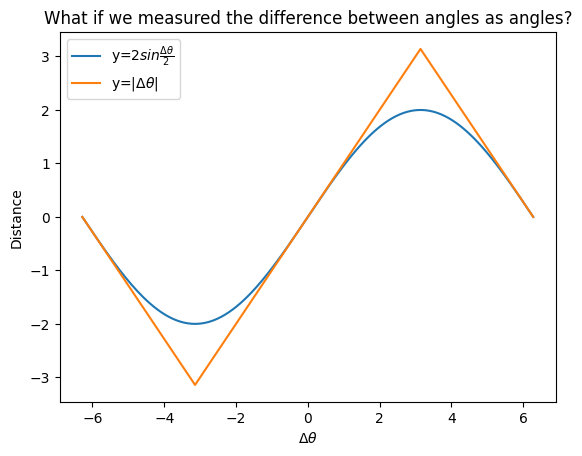

In [114]:
plt.plot(xs, ys1, label=r"y=$2 sin \frac{\Delta \theta}{2}$")
plt.plot(xs, ys4, label=r"y=$|\Delta \theta|$")
plt.legend()
plt.xlabel(r"$\Delta \theta$")
plt.ylabel(r"Distance")
plt.title("What if we measured the difference between angles as angles?");

(Note that to actually get the second, piecewise linear, curve to come out right we need to say things like
\begin{equation}
y = \left| \left\{(\Delta \phi + \pi)\mod 4\pi\right\} - 2\pi\right|,
\end{equation}
which isn't much fun, but that isn't a dealbreaker in itself.)

## OK but does it work in practice?

So far, I have been using this representation to develop a least-squares algorithm for the RDAPS fringefit global stage. If it breaks I can always go back to the complex double-dimension representation, but so far it's been working OK and at some stage of data growth I hope to be able to remark, with mild smugness, that a factor of two is after all a factor of two. We'll see!